## Descripción del conjunto de datos

El conjunto de datos utilizado en este proyecto corresponde a los registros de consumo de gas del sector industrial atendido por Contugas. Cada registro representa una medición de consumo cada intervalo de tiempo y está compuesto por las siguientes columnas:

- **ID**: Código único del cliente industrial. Contamos con un total de 20 clientes.
- **fecha**: Fecha y hora de la medición.
- **presion**: Presión medida en el sistema de distribución.
- **volumen**: Volumen de gas consumido.
- **temperatura**: Temperatura registrada durante la medición.
- **mes**: Mes calendario correspondiente a la medición (valor numérico de 1 a 12).
- **dia**: Día de la semana en que se tomó la medición (de 1 a 6, siendo 1 el domingo).
- **hora**: Hora del día (formato 24 horas).

Este conjunto de datos será utilizado como insumo principal para identificar patrones de comportamiento y detectar posibles anomalías en el consumo de gas industrial.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

#1. Cargar y preparar los datos
df_base = pd.read_csv("data.csv", sep=";", parse_dates=["FECHA"])

# Renombrar columnas por compatibilidad
df_base.rename(columns={
    "FECHA": "time",
    "PRESION": "presion",
    "TEMPERATURA": "temperatura",
    "VOLUMEN": "volumen"
}, inplace=True)

# Organizar columnas
df = df_base[["K", "ID", "time", "presion", "temperatura", "volumen"]]

In [114]:
def ajustar_fechas_formato(fecha):
    if pd.isnull(fecha):
        return pd.NaT
    fecha = fecha.replace('a.m.', 'AM').replace('p.m.', 'PM')  # Normaliza AM/PM
    try:
        if ':' in fecha:
            return pd.to_datetime(fecha, format='%d/%m/%Y %I:%M:%S %p', errors='coerce')
        else:
            return pd.to_datetime(fecha, format='%d/%m/%Y', errors='coerce')
    except:
        return pd.NaT

df['time'] = df['time'].apply(ajustar_fechas_formato)

print(f"Fechas con problemas de conversión: {df['time'].isna().sum()}")

## Estadísticas descriptivas

Comenzamos con una exploración básica del conjunto de datos, con el fin de entender su estructura general, dimensiones, posibles valores faltantes y las principales estadísticas univariadas (media, desviación estándar, valores mínimos y máximos, entre otros). Esta exploración nos permitira identificar rápidamente problemas de calidad en los datos y establecer criterios preliminares para la detección de anomalías.


In [118]:
print("\nPrimeras filas:")
print(df.head())


Primeras filas:
     K  ID                time    presion  temperatura    volumen
0  414   1 2019-01-31 06:00:00  17.729719    28.766576  26.102865
1  415   1 2019-01-31 07:00:00  17.693210    28.138249  24.492739
2  417   1 2019-01-31 09:00:00  17.717018    28.478988  26.036619
3  418   1 2019-01-31 10:00:00  17.745201    28.377288  28.541832
4  419   1 2019-01-31 11:00:00  17.662240    28.780606  26.991910


In [119]:
# Exploración inicial
print(f"Dimensiones del dataset: {df.shape}")

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores faltantes por columna:")
print(df.isna().sum())

Dimensiones del dataset: (847969, 6)

Estadísticas descriptivas:
                   K             ID                           time  \
count  847969.000000  847969.000000                         847969   
mean   423985.000000      10.499623  2021-07-08 22:22:10.639916544   
min         1.000000       1.000000            2019-01-14 00:00:00   
25%    211993.000000       5.000000            2020-04-13 23:00:00   
50%    423985.000000      10.000000            2021-07-07 06:00:00   
75%    635977.000000      16.000000            2022-10-06 03:00:00   
max    847969.000000      20.000000            2024-01-02 00:15:00   
std    244787.709544       5.774859                            NaN   

             presion    temperatura        volumen  
count  847969.000000  847969.000000  847969.000000  
mean       16.072916      25.198138      62.327651  
min         0.000000      -5.257899       0.000000  
25%        17.097314      22.693014       0.000000  
50%        17.570446      25.379820    

## Distribuciones univariadas

Esta sección presenta las distribuciones individuales de las variables cuantitativas y categóricas contenidas en el conjunto de datos. Se grafican los histogramas o conteos para las variables: `presion`, `volumen`, `temperatura`, `mes`, `dia_semana` y `hora`. Esto permite identificar patrones generales, simetrías, asimetrías y posibles valores atípicos para cada variable.


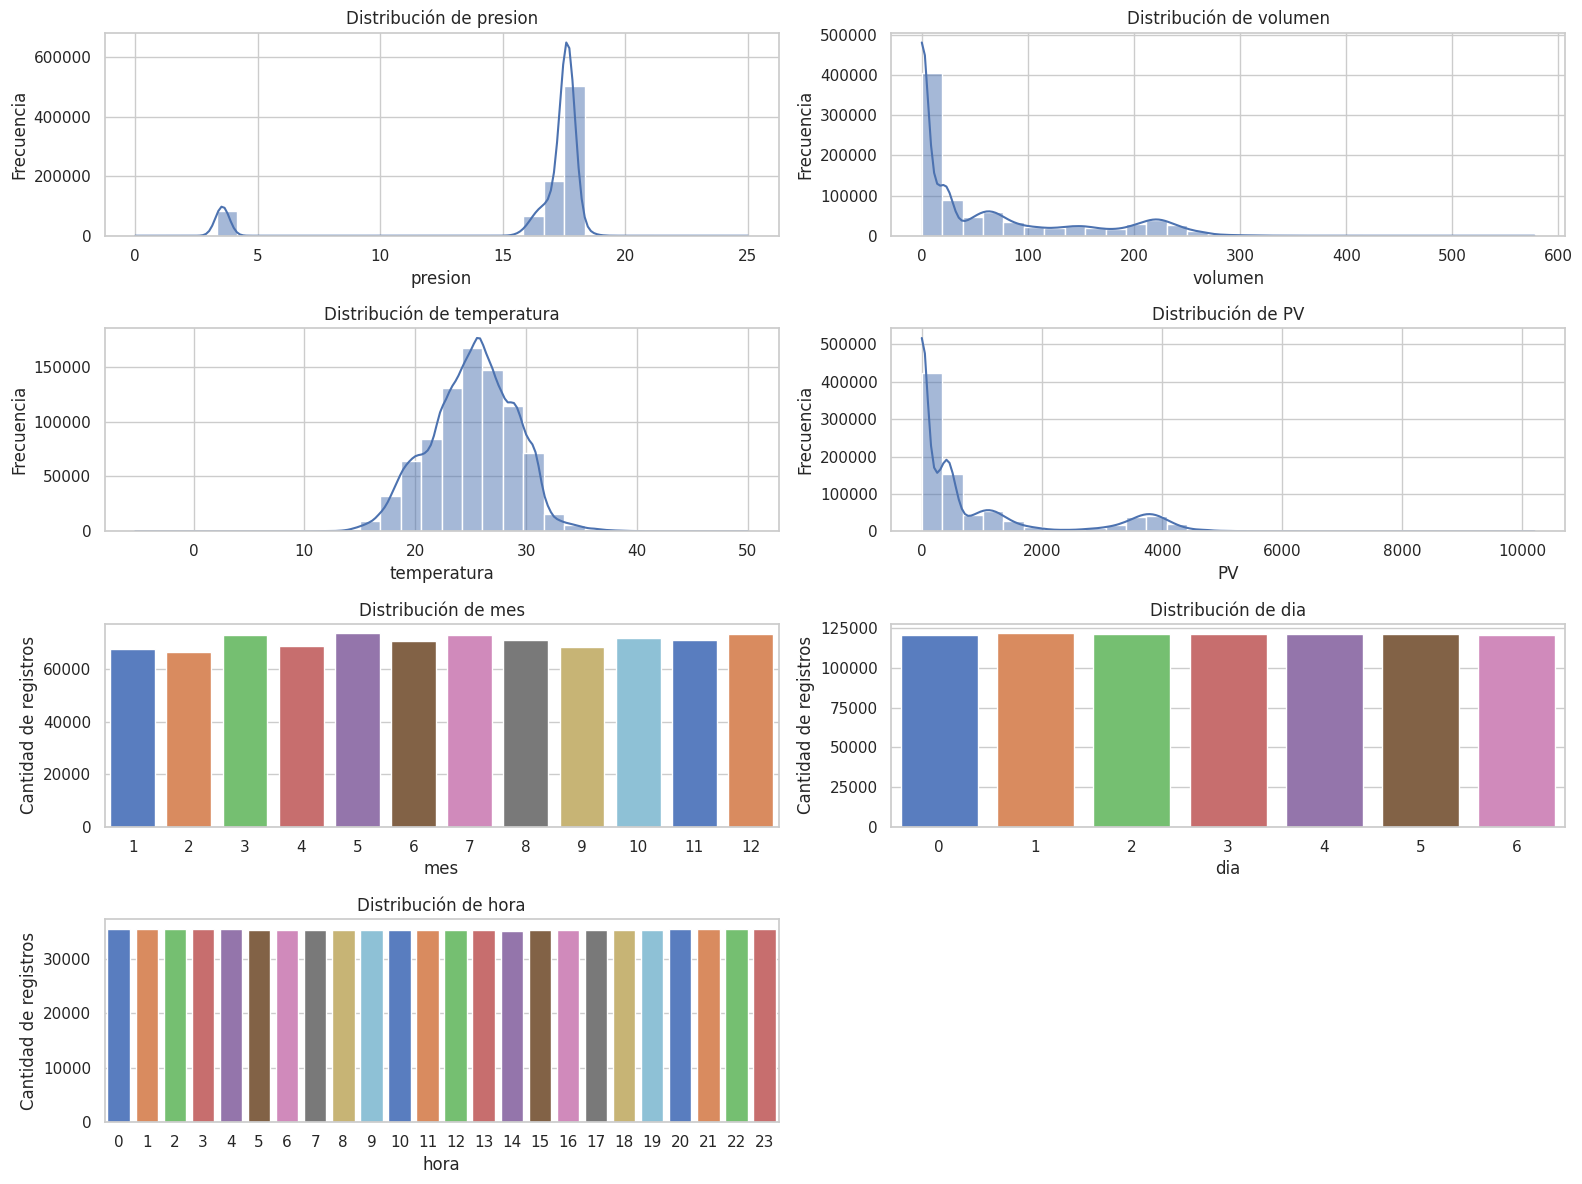

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# agregamos la nueva variable P*V, de la formula de los gases ideales P*V = T
df["PV"] = df["presion"] * df["volumen"]

# Variables numéricas continuas
variables_continuas = ['presion', 'volumen', 'temperatura', 'PV']
for i, var in enumerate(variables_continuas):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

# Variables categóricas ordenadas
# Crear columnas categóricas basadas en 'time'
df['mes'] = df['time'].dt.month                  # mes numérico (1-12)
df['dia'] = df['time'].dt.dayofweek       # 0=lunes, 6=domingo
df['hora'] = df['time'].dt.hour                  # hora en formato 24h

variables_categoricas = ['mes', 'dia', 'hora']
for j, var in enumerate(variables_categoricas):
    plt.subplot(4, 2, len(variables_continuas)+j+1)
    sns.countplot(x=var, data=df, palette='muted')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Cantidad de registros')

plt.tight_layout()
plt.show()

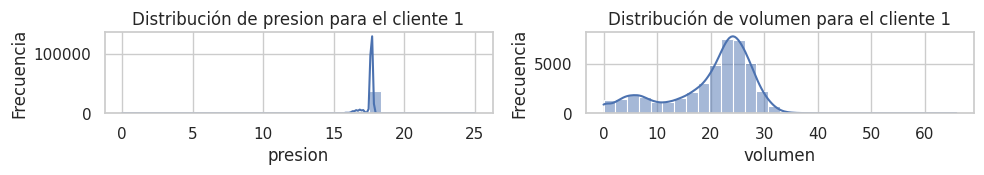

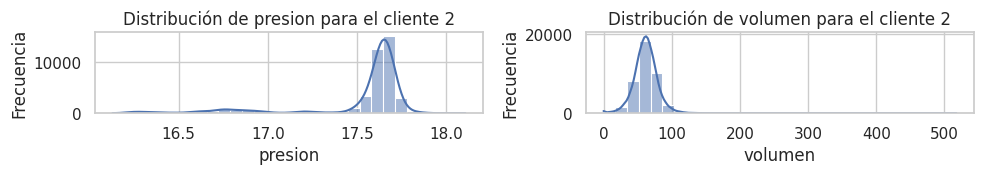

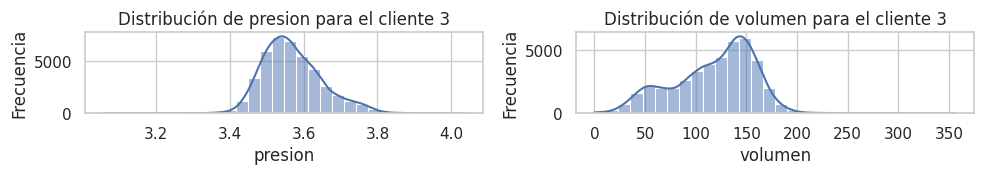

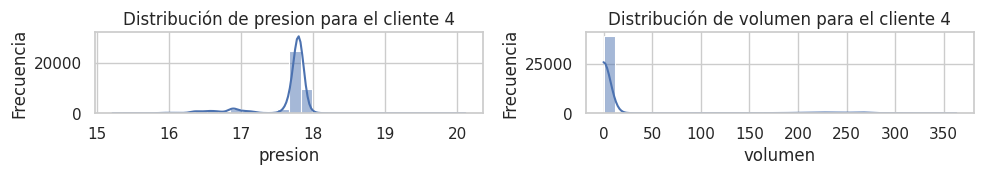

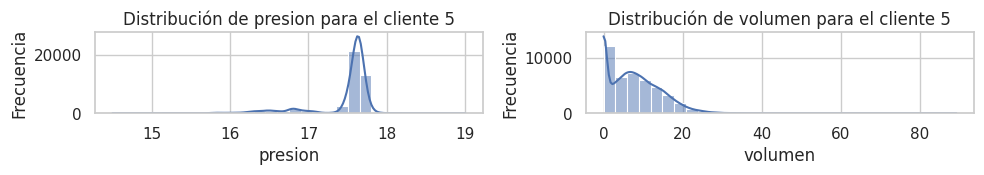

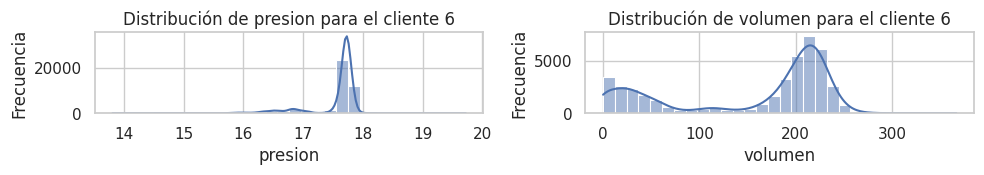

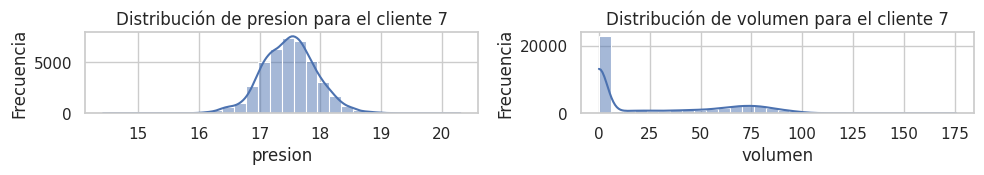

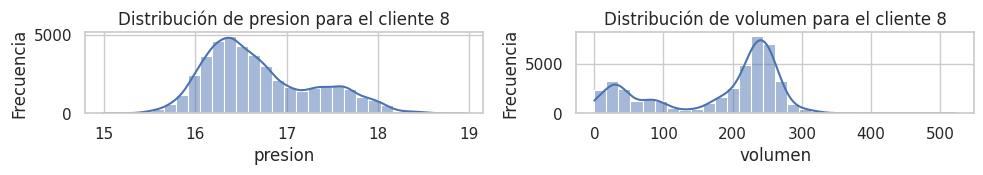

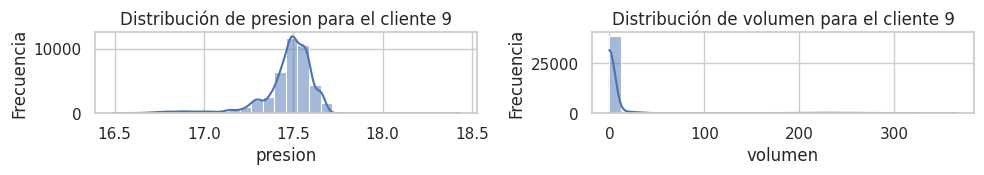

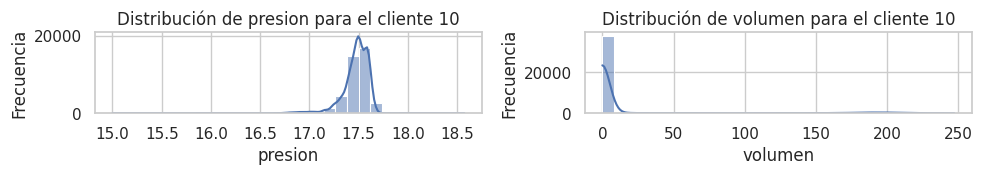

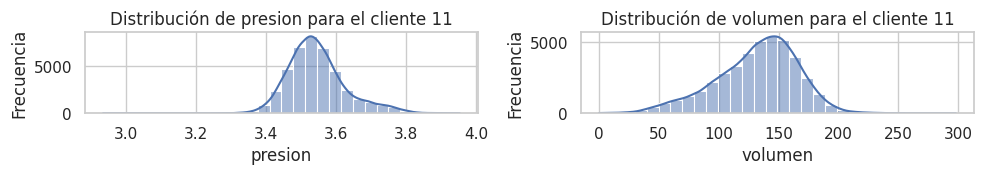

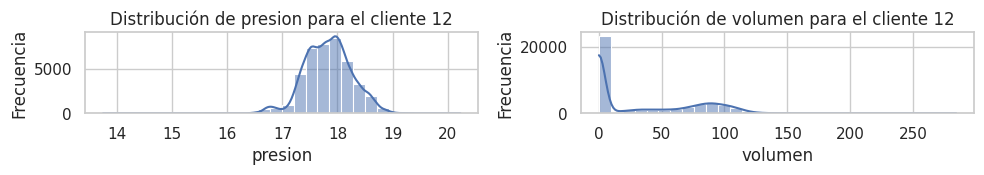

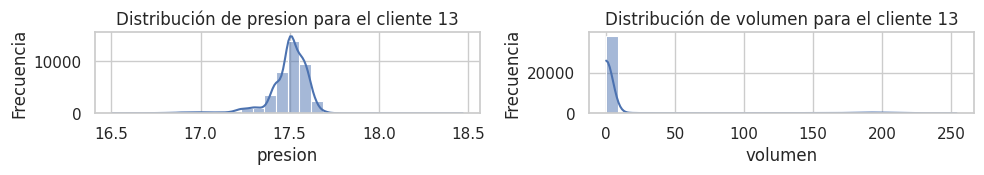

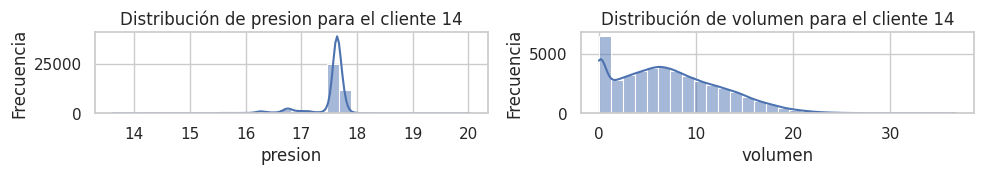

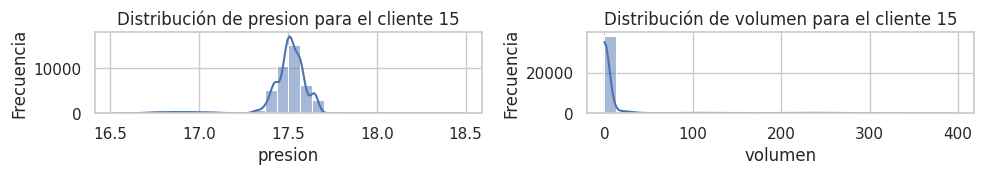

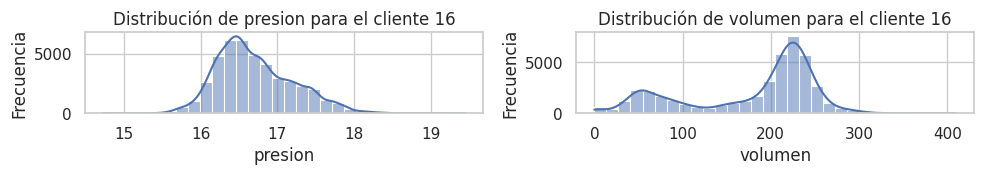

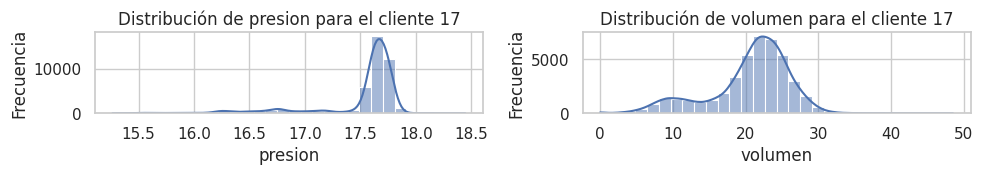

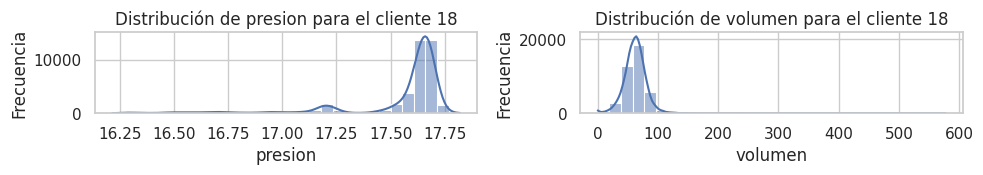

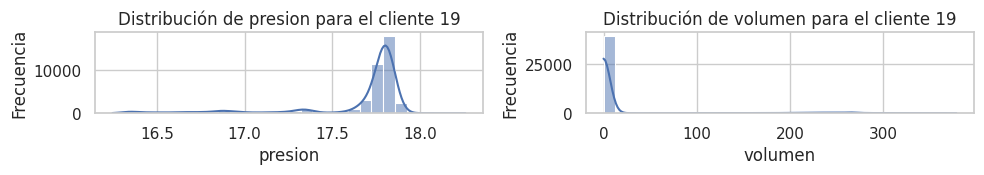

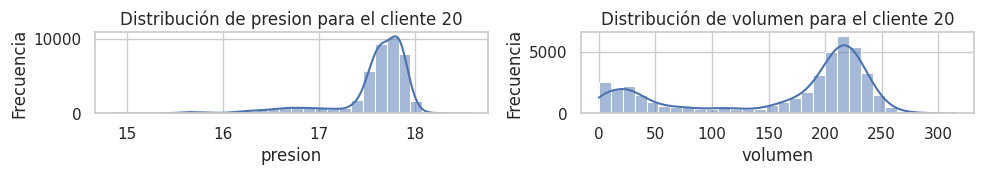

In [123]:
# Analizamos las distribución de las variables presion y volumen por cliente
variables_continuas = ['presion', 'volumen']

for cliente_id in df['ID'].unique():
    plt.figure(figsize=(10, 30))
    for i, var in enumerate(variables_continuas):
        plt.subplot(20, 2, i+1)
        sns.histplot(df[df['ID'] == cliente_id][var], kde=True, bins=30)
        plt.title(f'Distribución de {var} para el cliente {cliente_id}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

In [124]:
from scipy import stats

stat, p = stats.shapiro(df['presion'])
print(f'Estadístico de Shapiro para la variable presion: {stat:.4f}, p-valor: {p:.4f}')

stat, p = stats.shapiro(df['volumen'])
print(f'Estadístico de Shapiro para la variable volumen: {stat:.4f}, p-valor: {p:.4f}')

Estadístico de Shapiro para la variable presion: 0.4262, p-valor: 0.0000
Estadístico de Shapiro para la variable volumen: 0.7718, p-valor: 0.0000


##Correlación entre variables

De acuerdo al analisis anterior y la correlación entre variables, para el analisis y agrupamiento de clientes con caracteristicas similares, descartaremos el uso de la variable PV (presión x volumen) por tener una correlación muy alta con volumen (0.922). Esto indica que ambas variables contienen información muy similar.

Las variables a conserva en el analisis son:
- *Presión*: Presenta baja correlación con las demás variables, lo que sugiere que aporta información única al modelo.

- *Volumen*: Aunque está altamente correlacionada con PV, se prefiere conservar volumen por su interpretación directa y relevancia en el contexto del negocio.

- *Temperatura*: Tiene correlaciones moderadas con las demás variables, lo que indica que también aporta información valiosa en el proceso de inferencia.



In [125]:
correlation_matrix = df[['presion', 'volumen', 'temperatura', 'PV']].corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,presion,volumen,temperatura,PV
presion,1.000000,-0.303607,-0.117813,0.069377
volumen,-0.303607,1.000000,0.334397,0.921695
temperatura,-0.117813,0.334397,1.000000,0.312962
PV,0.069377,0.921695,0.312962,1.000000


## Identificación de valores atípicos según norma OIML R 137-1

Para las variables `presion` y `temperatura`, en el contexto peruano, las normativas técnicas que regulan los rangos de presión y temperatura para la operación segura de sistemas de gas natural seco son establecidas por el Instituto Nacional de Calidad (INACAL). A continuación, se detallan las especificaciones relevantes:

*Instalaciones industriales*: La NTP 111.010 establece que las instalaciones internas industriales pueden operar con presiones de hasta 400 kPa (4 bar). Esta norma se aplica a sistemas que van desde la salida de la Estación de Regulación de Presión y Medición Primaria hasta los puntos de conexión de los equipos de consumo.

Líneas individuales interiores: 2,3 kPa (23 mbar)

La temperatura del gas se encuentra en un rango de -10 C y +60 C
Con base en estas referencias y distribuciones observadas, se identifican los valores que se desvían significativamente de los rangos operativos razonables. Para `volumen`, se aplica un enfoque basado en el rango intercuartílico (IQR), dada la variabilidad esperada por cliente.

Los valores identificados como atípicos se marcarán para futuras etapas del análisis y eventual modelado.

In [126]:
# Umbrales para condiciones normales de operación
presion_min, presion_max = 0, 23 # 2.3 KPa (23 mbar)
temp_min, temp_max = - 10,  60 # grados

# Identificación de valores atípicos
outliers_presion = df[(df['presion'] < presion_min) | (df['presion'] > presion_max)]
outliers_temp = df[(df['temperatura'] < temp_min) | (df['temperatura'] > temp_max)]

# Clasificación de valores atípicos en volumen
# Cálculo del rango intercuartílico (IQR)
Q1 = df['volumen'].quantile(0.25)
Q3 = df['volumen'].quantile(0.75)
IQR = Q3 - Q1

# Definición de umbrales para valores atípicos
vol_max = Q3 + 1.5 * IQR
# Un volumen < 0, es físicamente inconsistente
outliers_volumen = df[(df['volumen'] > vol_max)]

# Resultados
print(f"Valores atípicos en presión: {outliers_presion.shape[0]}")
print(f"Valores atípicos en temperatura: {outliers_temp.shape[0]}")
print(f"Valores atípicos en volumen: {outliers_volumen.shape[0]}")


Valores atípicos en presión: 2
Valores atípicos en temperatura: 0
Valores atípicos en volumen: 19035


19.035 valores atípicos en volumen, nos lleva a realizar un analisis por cliente, en el cual se evidencia como algunos clientes presentan valores extremos, reflejando la heterogeneidad del consumo entre clientes.  

Esto confirma que ciertos clientes tienen patrones de consumo significativamente distintos, en el cual se clasifico como valores atipicos un 2.2% aproximadamente del total de tus 847.969 registros

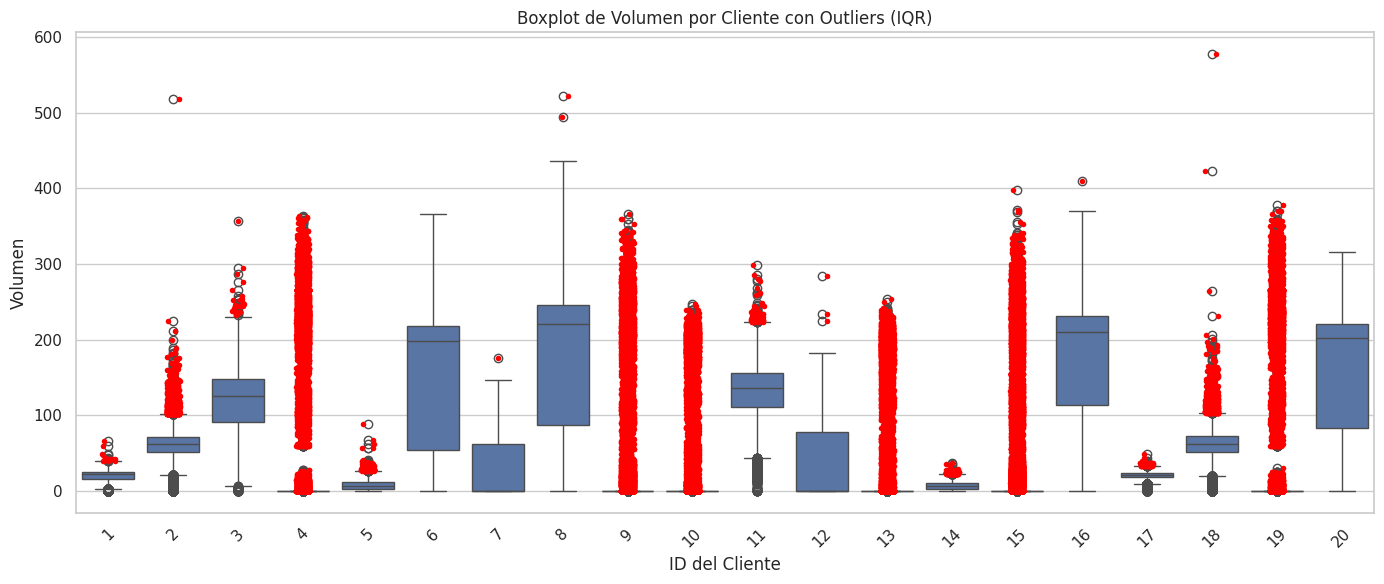

In [128]:
# Inicializar la columna de outliers como False
df['volumen_outlier'] = False

# Detectar outliers por cliente usando IQR
for cliente_id, grupo in df.groupby('ID'):
    Q1 = grupo['volumen'].quantile(0.25)
    Q3 = grupo['volumen'].quantile(0.75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    outliers = grupo['volumen'] > upper_bound
    df.loc[outliers.index, 'volumen_outlier'] = outliers

# Generar boxplot de volumen por cliente
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='ID', y='volumen')
sns.stripplot(data=df[df['volumen_outlier']], x='ID', y='volumen',
              color='red', size=4, jitter=True)
plt.title('Boxplot de Volumen por Cliente con Outliers (IQR)')
plt.xlabel('ID del Cliente')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df.drop('volumen_outlier', axis='columns', inplace=True)

## Boxplots de variables clave

Se visualizan los valores atípicos en las variables `presion`, `temperatura` y `volumen` mediante diagramas de caja (boxplots). Esta visualización nos permite observar la dispersión, los cuartiles y los posibles valores extremos para cada variable, facilitando el análisis exploratorio previo a la detección formal de anomalías.


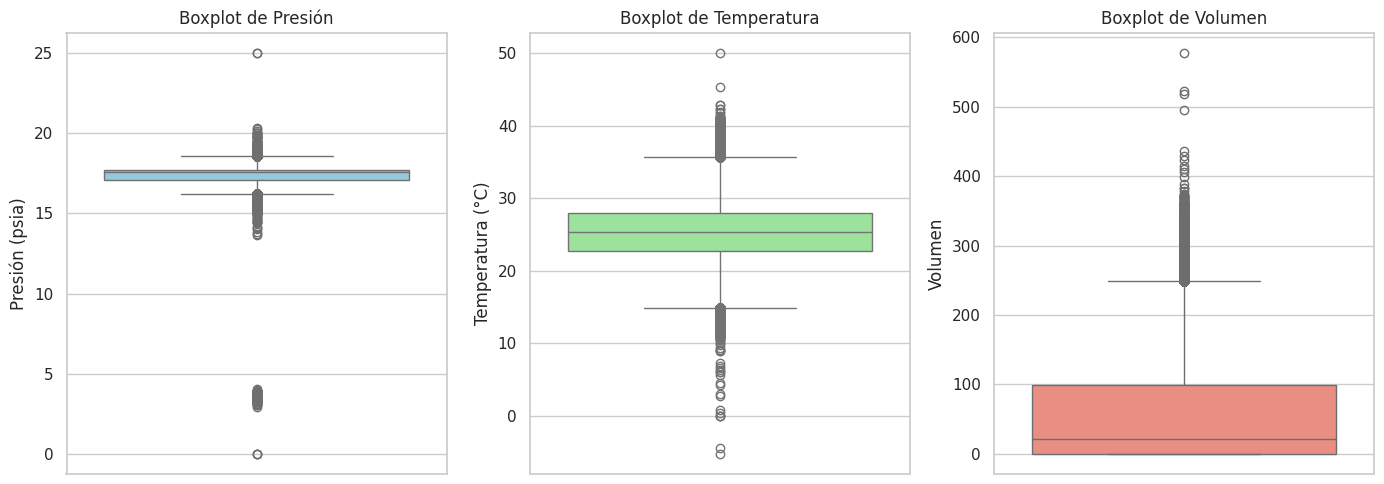

In [129]:
plt.figure(figsize=(14, 5))

# Presión
plt.subplot(1, 3, 1)
sns.boxplot(y=df['presion'], color='skyblue')
plt.title('Boxplot de Presión')
plt.ylabel('Presión (psia)')

# Temperatura
plt.subplot(1, 3, 2)
sns.boxplot(y=df['temperatura'], color='lightgreen')
plt.title('Boxplot de Temperatura')
plt.ylabel('Temperatura (°C)')

# Volumen
plt.subplot(1, 3, 3)
sns.boxplot(y=df['volumen'], color='salmon')
plt.title('Boxplot de Volumen')
plt.ylabel('Volumen')

plt.tight_layout()
plt.show()

El criterio para marcar outliears por 3 desviaciones estandar no aplica para las variables presion y volumen, al estar no seguir una distribución normal, razon por la cual se procede aplicar el criterior IQR

In [130]:
# Función para marcar outliers por 3 desviaciones estándar
def marcar_outliers(df, variable):
    media = df[variable].mean()
    std = df[variable].std()
    limite_inferior = media - 3 * std
    limite_superior = media + 3 * std

    return (df[variable] < limite_inferior) | (df[variable] > limite_superior)

# Aplicar detección por variable
outliers_presion = marcar_outliers(df, 'presion')
outliers_volumen = marcar_outliers(df, 'volumen')
outliers_temperatura = marcar_outliers(df, 'temperatura')

# Estimar porcentaje de anomalías
outlier_mask = outliers_presion | outliers_volumen | outliers_temperatura

# Total y porcentaje de anomalías
total_outliers = outlier_mask.sum()
porcentaje_outliers = total_outliers / len(df)

print(f"Número total de anomalías: {total_outliers}")
print(f"Porcentaje de anomalías: {porcentaje_outliers:.6f}")

Número total de anomalías: 29372
Porcentaje de anomalías: 0.034638


In [134]:
factor = 2.5  # en lugar de 1.5

def detectar_outliers_IQR(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - factor * IQR
    limite_superior = Q3 + factor * IQR
    return (df[variable] < limite_inferior) | (df[variable] > limite_superior)

mask_out_presion = detectar_outliers_IQR(df, 'presion')
mask_out_volumen = detectar_outliers_IQR(df, 'volumen')
mask_out_temp = detectar_outliers_IQR(df, 'temperatura')

# Combinar todas las condiciones
outlier_mask = mask_out_presion | mask_out_volumen | mask_out_temp

# Número y porcentaje
total_outliers = outlier_mask.sum()
print(f"Número total de anomalías: {total_outliers}")
print(f"Porcentaje de anomalías: {total_outliers / len(df):.6f}")

Número total de anomalías: 85333
Porcentaje de anomalías: 0.100632


In [135]:
# Etiquetar las filas como anomalías (1) o no (0)
df['es_anomalia_IQR2_5'] = outlier_mask.astype(int)

## Análisis exploratorio por cliente

Ahora analizamos el comportamiento individual de cada cliente con respecto a las variables `presion`, `temperatura` y `volumen`. Se calculan estadísticas agregadas por cliente (media, mediana y desviación estándar) y se visualizan mediante gráficos comparativos. Lo que nos permite identificar clientes con comportamientos fuera de lo esperado o con alta variabilidad, lo cual puede ser indicativo de anomalías sistemáticas o condiciones operativas particulares.


In [136]:
# Cálculo de estadísticas agregadas por cliente
cliente_stats = df.groupby('ID')[['presion', 'temperatura', 'volumen']].agg(['mean', 'median', 'std']).reset_index()
cliente_stats.columns = ['ID',
                         'presion_mean', 'presion_median', 'presion_std',
                         'temperatura_mean', 'temperatura_median', 'temperatura_std',
                         'volumen_mean', 'volumen_median', 'volumen_std']

print(cliente_stats)


    ID  presion_mean  presion_median  presion_std  temperatura_mean  \
0    1     17.534891       17.651434     0.390665         25.573812   
1    2     17.526440       17.637486     0.318984         27.673040   
2    3      3.569593        3.559350     0.080619         26.348434   
3    4     17.639754       17.779337     0.390818         23.241102   
4    5     17.489345       17.614668     0.370395         23.665282   
5    6     17.569108       17.707247     0.396870         26.393254   
6    7     17.490812       17.493758     0.450059         23.622548   
7    8     16.705630       16.567409     0.598608         26.814551   
8    9     17.466627       17.497293     0.157897         22.073596   
9   10     17.473633       17.495297     0.135482         23.500526   
10  11      3.545512        3.535771     0.082752         26.307152   
11  12     17.833667       17.834866     0.418490         26.689551   
12  13     17.492521       17.511078     0.120068         21.591365   
13  14

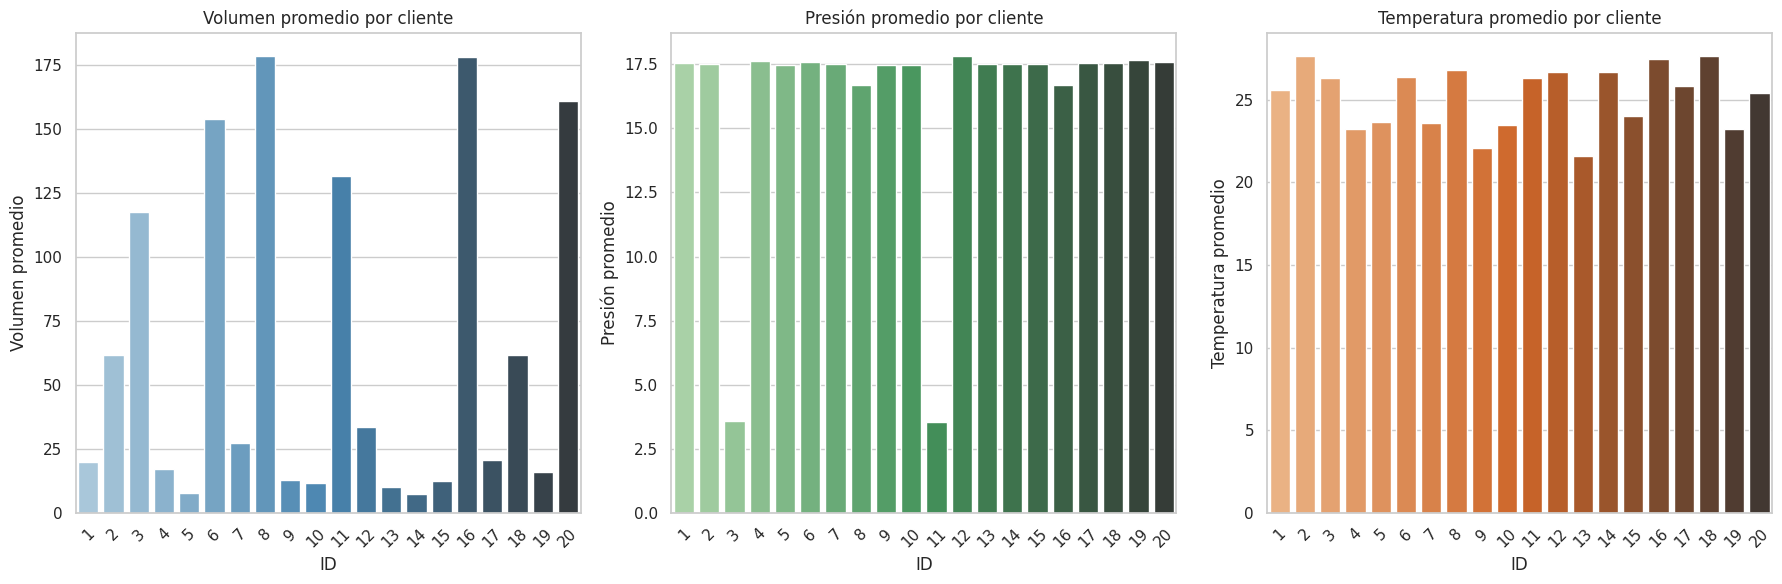

In [138]:
# Gráficos de barras comparativos por cliente
plt.figure(figsize=(18, 6))

# Promedio de volumen por cliente
plt.subplot(1, 3, 1)
sns.barplot(x='ID', y='volumen_mean', data=cliente_stats, palette='Blues_d')
plt.title('Volumen promedio por cliente')
plt.ylabel('Volumen promedio')
plt.xticks(rotation=45)

# Promedio de presión por cliente
plt.subplot(1, 3, 2)
sns.barplot(x='ID', y='presion_mean', data=cliente_stats, palette='Greens_d')
plt.title('Presión promedio por cliente')
plt.ylabel('Presión promedio')
plt.xticks(rotation=45)

# Promedio de temperatura por cliente
plt.subplot(1, 3, 3)
sns.barplot(x='ID', y='temperatura_mean', data=cliente_stats, palette='Oranges_d')
plt.title('Temperatura promedio por cliente')
plt.ylabel('Temperatura promedio')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas
X = cliente_stats.drop(columns=['ID'])
X_scaled = StandardScaler().fit_transform(X)

# Clustering con HDBSCAN sobre el espacio reducido
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
cliente_stats['cluster'] = clusterer.fit_predict(X_scaled)

In [141]:
cliente_stats[['ID', 'cluster']]

,ID,cluster
0,1,2
1,2,3
2,3,0
3,4,6
4,5,5
5,6,1
6,7,5
7,8,1
8,9,7
9,10,8


## Agrupamiento de clientes por comportamiento usando tsfresh

Dado que los datos corresponden a series de tiempo con registros horarios de consumo para cada cliente, se emplea la librería `tsfresh` para extraer automáticamente características estadísticas relevantes a partir de las series temporales individuales.

Posteriormente, se aplica reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA) para visualizar los perfiles en un espacio bidimensional, seguido de un algoritmo de clustering (KMeans) para agrupar clientes con comportamientos similares.

Estos grupos servirán como insumo para entrenar modelos predictivos diferenciados por clientes con caracteristicas de consumo similares, permitiendo una mejor generalización y detección de anomalías específicas al contexto operativo de cada grupo.


Se incluyen varialbes temporales mes, dia y hora haciendo la transformación a varaibles circulares para representar patrones temporales estacionales.


In [142]:
!pip install tsfresh

In [143]:
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from sklearn.feature_selection import VarianceThreshold

# Paso 1: Eliminar variables de baja varianza
def eliminar_baja_varianza(X, umbral=0.01):
    selector = VarianceThreshold(threshold=umbral)
    X_filtrado = selector.fit_transform(X)
    columnas_filtradas = X.columns[selector.get_support()]
    return pd.DataFrame(X_filtrado, columns=columnas_filtradas, index=X.index)

# Paso 2: Eliminar variables altamente correlacionadas
def eliminar_alta_correlacion(X, umbral=0.95, plot=False):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Encontrar columnas con correlación mayor al umbral
    columnas_para_eliminar = [column for column in upper.columns if any(upper[column] > umbral)]

    if plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
        plt.title('Matriz de Correlación')
        plt.show()

    return X.drop(columns=columnas_para_eliminar), columnas_para_eliminar

# Preparar datos para tsfresh: cada punto con ID (cliente), time y valor (volumen, presión, temperatura)
cliente_stats_tsfresh = df[['ID', 'time', 'volumen', 'presion', 'temperatura']].copy()

# Extraer características con TSFresh
features = extract_features(cliente_stats_tsfresh,
                            column_id="ID",
                            column_sort="time",
                            default_fc_parameters=EfficientFCParameters(),
                            n_jobs=0)  # usa todos los cores

# IMPUTACIÓN DE NULOS
features_imputed = impute(features)

Feature Extraction: 100%|██████████| 60/60 [17:12<00:00, 17.21s/it]


In [154]:
# Aplicar el pipeline
features_clean = features_imputed.dropna(axis=1)

# se eliminan todas aquellas variables con una varianza inferior al 0.1 (umbral=0.01)
X_clean = eliminar_baja_varianza(features_clean, umbral=0.1)
# se eliminan todas las variables con correlacion mayor al 0.8 (umbral=0.95)
X_, eliminadas = eliminar_alta_correlacion(X_clean, umbral=0.7, plot=False)

print(f"Número de features originales: {features_clean.shape[1]}")
print(f"Número de features tras baja varianza: {X_clean.shape[1]}")
print(f"Número de features finales tras eliminar correlacionadas: {X_.shape[1]}")

Número de features originales: 2331
Número de features tras baja varianza: 1702
Número de features finales tras eliminar correlacionadas: 147


In [148]:
pip install umap-learn

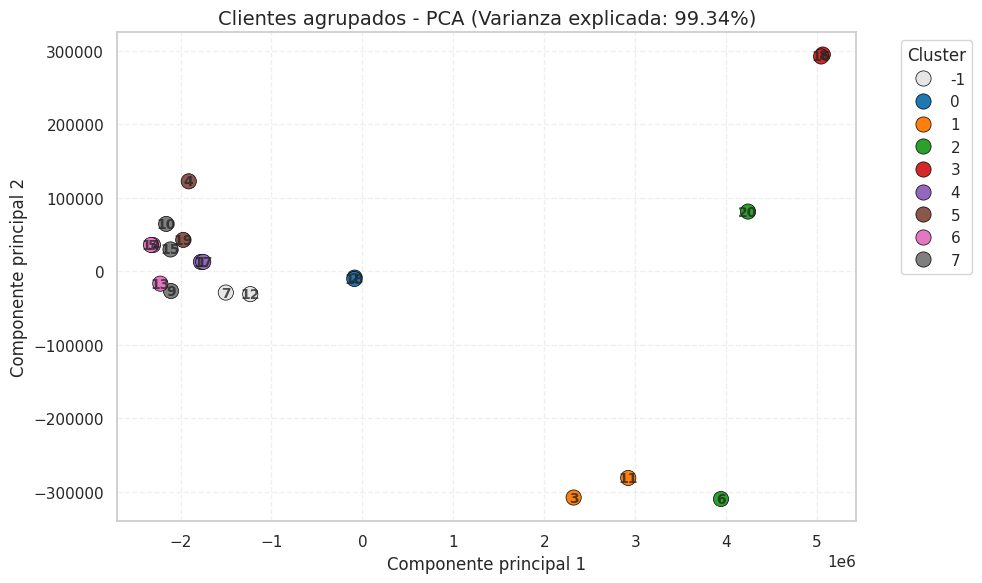

In [156]:
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

# Reducción de dimensión con UMAP
#umap_model = umap.UMAP(n_components=2, random_state=42)
#umap_result = umap_model.fit_transform(X_)

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_)

# Clustering con HDBSCAN sobre el espacio reducido
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
#labels = clusterer.fit_predict(umap_result)
labels = clusterer.fit_predict(pca_result)

# guardamos los cluster generados para cada conjunto de clientes
clientes_clusters = pd.DataFrame({
    'id': X_.index,
    'cluster': labels
})

# Crear paleta personalizada (blanco para cluster -1)
# Identificar clusters (excluyendo -1 que es ruido)
unique_labels = np.unique(labels)
valid_labels = [l for l in unique_labels if l != -1]

# Crear paleta de colores para clusters válidos
base_palette = sns.color_palette("tab10", len(valid_labels))
custom_palette = {label: base_palette[i] for i, label in enumerate(valid_labels)}

# Añadir color gris para el cluster -1 (ruido)
if -1 in unique_labels:
    custom_palette[-1] = (0.9, 0.9, 0.9)

# Dibujar gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=labels,
    palette=custom_palette,
    s=120,
    edgecolor='black',
    linewidth=0.5
)

# Etiquetas de cliente
for i, cliente in enumerate(X_.index):
    plt.annotate(
        str(cliente),
        (pca_result[i, 0], pca_result[i, 1]),
        fontsize=10,
        weight='bold',
        ha='center',
        va='center',
        alpha=0.8
    )

# Títulos y leyenda
plt.title(f"Clientes agrupados - PCA (Varianza explicada: {pca.explained_variance_ratio_.sum():.2%})", fontsize=14)
plt.xlabel("Componente principal 1", fontsize=12)
plt.ylabel("Componente principal 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [159]:
clientes_clusters

,id,cluster
0,1,4
1,2,0
2,3,1
3,4,5
4,5,6
5,6,2
6,7,-1
7,8,3
8,9,7
9,10,7


In [158]:
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import umap
import numpy as np

# 1. Calcular distancias en el espacio original
orig_dist = pairwise_distances(X_)

# 2. PCA: Reducción a 2 componentes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_)
pca_dist = pairwise_distances(pca_result)

# 3. UMAP: Reducción a 2 dimensiones
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X_)
umap_dist = pairwise_distances(umap_result)

# 4. Calcular correlación entre distancias originales y reducidas
pca_corr = np.corrcoef(orig_dist.flatten(), pca_dist.flatten())[0, 1]
umap_corr = np.corrcoef(orig_dist.flatten(), umap_dist.flatten())[0, 1]

# 5. Mostrar resultados
print(f"Correlación distancias originales vs PCA (2D):   {pca_corr:.4f}")
print(f"Correlación distancias originales vs UMAP (2D):  {umap_corr:.4f}")

#Correlación distancias originales vs PCA (2D):   0.9999
#Correlación distancias originales vs UMAP (2D):  0.8971

Correlación distancias originales vs PCA (2D):   0.9996
Correlación distancias originales vs UMAP (2D):  0.9356


A continuación presentamos las características que explican mejor la separación visual observada en el gráfico PCA.

In [157]:
# Importancia de las variables en cada componente
pca_weights = pd.DataFrame(pca.components_, columns=X_.columns, index=['PCA1', 'PCA2'])

# Mostrar las variables que más pesan en cada componente
top_pca1 = pca_weights.loc['PCA1'].abs().sort_values(ascending=False).head(5)
top_pca2 = pca_weights.loc['PCA2'].abs().sort_values(ascending=False).head(5)

print("5 Variables que más influyen en PCA1:")
print(top_pca1)
print("\n5 Variables que más influyen en PCA2:")
print(top_pca2)

5 Variables que más influyen en PCA1:
volumen__sum_values                                0.999719
volumen__fft_coefficient__attr_"real"__coeff_24    0.009262
volumen__fft_coefficient__attr_"real"__coeff_4     0.008280
volumen__fft_coefficient__attr_"real"__coeff_11    0.006756
volumen__fft_coefficient__attr_"real"__coeff_1     0.006669
Name: PCA1, dtype: float64

5 Variables que más influyen en PCA2:
volumen__fft_coefficient__attr_"real"__coeff_4     0.606262
volumen__fft_coefficient__attr_"real"__coeff_1     0.539993
volumen__fft_coefficient__attr_"real"__coeff_2     0.441212
volumen__fft_coefficient__attr_"real"__coeff_11    0.149117
volumen__fft_coefficient__attr_"real"__coeff_18    0.142888
Name: PCA2, dtype: float64


In [129]:
# Reemplazar cluster -1 por 8 para cliente 4
#clientes_clusters.loc[(clientes_clusters['id'] == 4) & (clientes_clusters['cluster'] == -1), 'cluster'] = 8
#clientes_clusters.loc[(clientes_clusters['id'] == 19) & (clientes_clusters['cluster'] == -1), 'cluster'] = 9

# Realizamos el merge para agregar la columna 'cluster' al DataFrame df
df = df.merge(clientes_clusters, on='id', how='left')

# Mostrar el resumen
# Agrupar por 'id' y 'cluster' y contar la cantidad de registros
print(df.groupby(['id', 'cluster']).size().reset_index(name='cantidad registros'))
print(df.groupby('cluster')['id'].nunique().reset_index(name='cantidad clientes'))

    id  cluster  cantidad registros
0    1        5               43420
1    2        0               41382
2    3        1               42248
3    4        8               42305
4    5        6               43415
5    6        3               42808
6    7        2               41776
7    8        4               43147
8    9        7               42428
9   10        7               41060
10  11        1               42248
11  12        2               41776
12  13        7               41059
13  14        6               43415
14  15        7               42428
15  16        4               43147
16  17        5               43412
17  18        0               41382
18  19        9               42305
19  20        3               42808
   cluster  cantidad clientes
0        0                  2
1        1                  2
2        2                  2
3        3                  2
4        4                  2
5        5                  2
6        6                  2
7   

In [160]:
df

,K,ID,time,presion,temperatura,volumen,PV,mes,dia,hora,es_anomalia_IQR1_5,es_anomalia_IQR2_5
0,414,1,2019-01-31 06:00:00,17.729719,28.766576,26.102865,462.796468,1,3,6,0,0
1,415,1,2019-01-31 07:00:00,17.693210,28.138249,24.492739,433.355181,1,3,7,0,0
2,417,1,2019-01-31 09:00:00,17.717018,28.478988,26.036619,461.291240,1,3,9,0,0
3,418,1,2019-01-31 10:00:00,17.745201,28.377288,28.541832,506.480551,1,3,10,0,0
4,419,1,2019-01-31 11:00:00,17.662240,28.780606,26.991910,476.737584,1,3,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
847964,845045,20,2023-08-30 22:00:00,16.544629,23.366961,20.097487,332.505470,8,2,22,0,0
847965,845063,20,2023-08-31 16:00:00,16.829434,25.136469,231.574511,3897.267892,8,3,16,0,0
847966,845080,20,2023-09-01 09:00:00,16.841228,24.645535,212.489089,3578.577087,9,4,9,0,0
847967,845097,20,2023-09-02 02:00:00,16.786944,21.479220,7.503922,125.967923,9,5,2,0,0


In [162]:
# Guardar el DataFrame como un archivo CSV
df.to_csv('base_anomalias.csv', index=False)

# Guardar el DataFrame como un archivo Parquet
df.to_parquet('base_anomalias.parquet', index=False)